# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

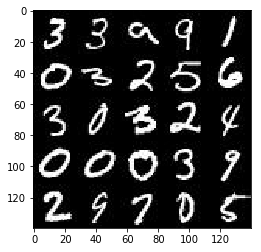

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

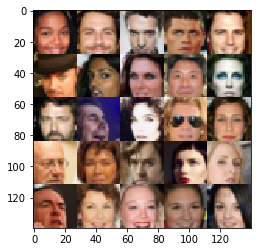

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_input_images = tf.placeholder(tf.float32, shape = (None, image_width, image_height, image_channels), name='real_input_images')
    z_inputs = tf.placeholder(tf.float32, shape = (None, z_dim), name='z_inputs')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')

    return real_input_images, z_inputs, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

## After first review, I added leaky_relu. This is version 2.

In [6]:
# create a Leaky RelU activation function 
# reference: 'Hands-On Machine Learning with Scikit-Learn and TensorFlow' by Aurélien Géron
def leaky_relu(x, alpha=0.1, name='leaky_relu'):
    return tf.maximum(x, alpha * x, name=name)

## After first review, I was modifyed. This is version 2.

In [7]:
def discriminator_v2(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    
    with tf.variable_scope('discriminator', reuse = reuse):
        # 1st Convolutional Layer w/ leaky_relu activation and w/o batch norm
        Lrelu1 = tf.layers.conv2d(
                                  inputs = images,
                                  filters = 64,
                                  kernel_size = (3,3),
                                  strides=(2,2),
                                  padding='same',
                                  kernel_initializer=tf.contrib.layers.xavier_initializer(),  
                                  activation = leaky_relu
                                  )
        Lrelu1 = tf.nn.dropout(Lrelu1, 0.8)
        
        # 2nd Convolutional Layer w/ leaky_relu activation and batch norm
        Lrelu2 = tf.layers.conv2d(
                                  inputs = Lrelu1,
                                  filters = 128,
                                  kernel_size = (3,3),
                                  strides=(2,2),
                                  padding='same',
                                  kernel_initializer=tf.contrib.layers.xavier_initializer(),  
                                  activation = None
                                  )
        Lrelu2 = tf.layers.batch_normalization(Lrelu2, training=True)
        Lrelu2 = leaky_relu(Lrelu2) #note: have to apply leaky_relu after batch norm
        Lrelu2 = tf.nn.dropout(Lrelu2, 0.8)
        
        # 3rd Convolutional Layer w/ leaky_relu activation and batch norm
        Lrelu3 = tf.layers.conv2d(
                                  inputs = Lrelu2,
                                  filters = 256,
                                  kernel_size = (3,3),
                                  strides=(2,2),
                                  padding='same',
                                  kernel_initializer=tf.contrib.layers.xavier_initializer(),  
                                  activation = None
                                  )
        Lrelu3 = tf.layers.batch_normalization(Lrelu3, training=True)
        Lrelu3 = leaky_relu(Lrelu3)
        Lrelu3 = tf.nn.dropout(Lrelu3, 0.8)
        
        # 4th Convolutional Layer w/ leaky_relu activation and batch norm
        Lrelu4 = tf.layers.conv2d(
                                  inputs = Lrelu3,
                                  filters = 512,
                                  kernel_size = (3,3),
                                  strides=(2,2),
                                  padding='same',
                                  kernel_initializer=tf.contrib.layers.xavier_initializer(),  
                                  activation = None
                                  )
        Lrelu4 = tf.layers.batch_normalization(Lrelu4, training=True)
        Lrelu4 = leaky_relu(Lrelu4)
        Lrelu4 = tf.nn.dropout(Lrelu4, 0.8)
        
        # Flattened Layer
        flat = tf.contrib.layers.flatten(Lrelu4)
        
        # Fully-Connected layer w/ one unit
        logits = tf.layers.dense(flat, 1)
        
        # Sigmoid Output
        out = tf.sigmoid(logits)
        
    return (out, logits)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator_v2, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

## After first review, I was modifyed. This is version 2.

In [8]:
def generator_v2(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function

    with tf.variable_scope('generator', reuse=not(is_train)):
        # First fully connected layer
        connect_layer = tf.layers.dense(
                                        inputs = z, 
                                        units = 2*2*512,
                                        kernel_initializer=tf.contrib.layers.xavier_initializer()
                                        )
        # Reshape it to start the convolutional stack
        connect_layer = tf.reshape(connect_layer, (-1, 2, 2, 512))
        connect_layer = tf.layers.batch_normalization(connect_layer, training=is_train)
        Lrelu0 = leaky_relu(connect_layer)
       
        # 1st 'Deconvolutional'-layer w/ batch normalization
        Lrelu1 = tf.layers.conv2d_transpose(
                                            inputs = Lrelu0, 
                                            filters = 256, 
                                            kernel_size = (3,3),
                                            strides= (2,2),
                                            padding='same',
                                            kernel_initializer=tf.contrib.layers.xavier_initializer(),
                                            activation = None
                                            )        
        Lrelu1 = tf.layers.batch_normalization(Lrelu1, training=is_train)
        Lrelu1 = leaky_relu(Lrelu1)
       
        # 2nd 'Deconvolutional'-layer w/ batch normalization
        Lrelu2 = tf.layers.conv2d_transpose(
                                            inputs = Lrelu1, 
                                            filters = 128, 
                                            kernel_size = (4,4),
                                            strides= (1,1),
                                            padding='valid',
                                            kernel_initializer=tf.contrib.layers.xavier_initializer(),
                                            activation = None
                                            )  
        Lrelu2 = tf.layers.batch_normalization(Lrelu2, training=is_train)
        Lrelu2 = leaky_relu(Lrelu2)
    
        # 3rd 'Deconvolutional'-layer w/ batch normalization
        Lrelu3 = tf.layers.conv2d_transpose(
                                            inputs = Lrelu2, 
                                            filters = 64, 
                                            kernel_size = (3,3),
                                            strides= (2,2),
                                            padding='same',
                                            kernel_initializer=tf.contrib.layers.xavier_initializer(),
                                            activation = None
                                            )
        Lrelu3 = tf.layers.batch_normalization(Lrelu3, training=is_train)
        Lrelu3 = leaky_relu(Lrelu3)
        
        # 4th 'Deconvolutional'-layer w/ batch normalization
        Lrelu4 = tf.layers.conv2d_transpose(
                                            inputs = Lrelu3, 
                                            filters = 32, 
                                            kernel_size = (5,5),
                                            strides= (1,1),
                                            padding='same',
                                            kernel_initializer=tf.contrib.layers.xavier_initializer(),
                                            activation = None
                                            )
        Lrelu4 = tf.layers.batch_normalization(Lrelu4, training=is_train)
        Lrelu4 = leaky_relu(Lrelu4)
        
        # Output layer
        out = tf.layers.conv2d_transpose(
                                            inputs = Lrelu3, 
                                            filters = out_channel_dim, 
                                            kernel_size = (3,3), 
                                            strides= (2,2), 
                                            padding='same',
                                            kernel_initializer=tf.contrib.layers.xavier_initializer(),
                                            activation = tf.tanh
                                            )

        return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator_v2, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

## After first review, I was modifyed. This is version 2.

In [9]:
def model_loss_v2(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator_v2(input_z, out_channel_dim, is_train=True)
   
    (d_model_real, d_logits_real) = discriminator_v2(input_real, reuse = False)
    (d_model_fake, d_logits_fake) = discriminator_v2(g_model, reuse=True)

    # parameter for label smoothing
    label_smooth = 0.1;
    
    # label smoothing applied to real logits labels
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)*(1-label_smooth)))
    
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    
    # the generator losses use the fake image logits
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    # Discriminator total loss is the sum of the losses for real and fake images
    d_loss = d_loss_real + d_loss_fake

    return (d_loss, g_loss)
    
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss_v2)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

## After first review, I was modifyed. This is version 2.

In [10]:
def model_opt_v2(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    # Get the trainable_variables split into Generator and Discriminator parts
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Adam Optimizer
    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS) 
    with tf.control_dependencies([op for op in update_ops if op.name.startswith('generator')]):
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return (d_train_opt, g_train_opt)

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt_v2, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

## After first review, I was modifyed. This is version 2.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output_v2(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator_v2(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

## After first review, I was modifyed. This is version 2.

In [12]:
def train_v2(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    if(data_image_mode == 'RGB'):
        image_channels = 3
    else:
        image_channels = 1
        
    image_width = data_shape[1]
    image_height = data_shape[2]
    
    input_real, input_z, lr = model_inputs(image_width,
                                           image_height,
                                           image_channels,
                                           z_dim)
    
    d_loss,g_loss = model_loss_v2(input_real, input_z, image_channels)
    d_train_opt, g_train_opt = model_opt_v2(d_loss, g_loss, learning_rate, beta1)
    

    (samples, losses) = [], []
    print_every = 100
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        
        for epoch_i in range(epoch_count):
            steps = 0;
            
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                
                # re-scale images from [-0.5 0.5] to [-1 1] 
                batch_images *= 2
    
                # Sample random noise for Generator
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers. 
                # Run g_optim multiple times to ensure that d_loss does not go to zero 
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_train_opt, feed_dict={input_z: batch_z, lr: learning_rate})
                
                if steps % print_every == 0:
                    show_generator_output_v2(
                                          sess = sess,
                                          image_mode = data_image_mode,
                                          input_z = input_z,
                                          n_images = 25,
                                          out_channel_dim = image_channels
                                          )
                    
                    # get the losses and print them out
                    train_loss_d = sess.run(d_loss, {input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Batch {}".format(steps),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

## After first review, I was modifyed. This is version 2.

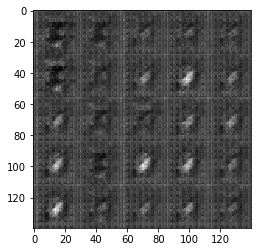

Epoch 1/2... Batch 100 Discriminator Loss: 1.4504... Generator Loss: 0.7412


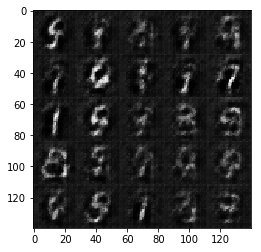

Epoch 1/2... Batch 200 Discriminator Loss: 1.3247... Generator Loss: 0.6319


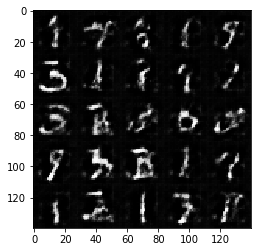

Epoch 1/2... Batch 300 Discriminator Loss: 1.1515... Generator Loss: 0.8756


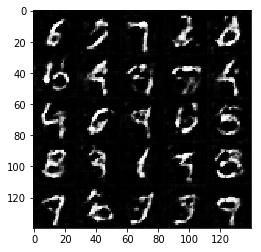

Epoch 1/2... Batch 400 Discriminator Loss: 1.2456... Generator Loss: 0.7563


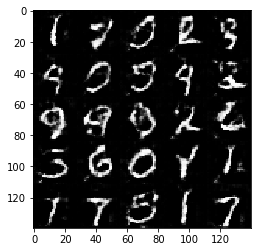

Epoch 1/2... Batch 500 Discriminator Loss: 1.1177... Generator Loss: 1.2983


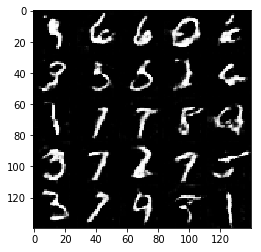

Epoch 1/2... Batch 600 Discriminator Loss: 1.1938... Generator Loss: 0.6969


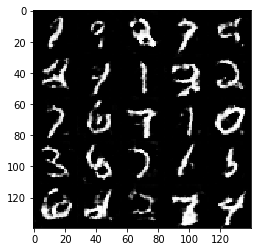

Epoch 1/2... Batch 700 Discriminator Loss: 1.2096... Generator Loss: 1.4053


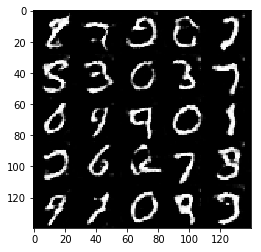

Epoch 1/2... Batch 800 Discriminator Loss: 1.2819... Generator Loss: 0.5812


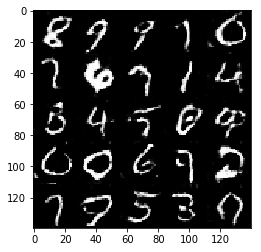

Epoch 1/2... Batch 900 Discriminator Loss: 1.4679... Generator Loss: 0.4671


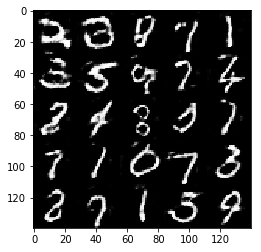

Epoch 2/2... Batch 100 Discriminator Loss: 1.5912... Generator Loss: 0.3908


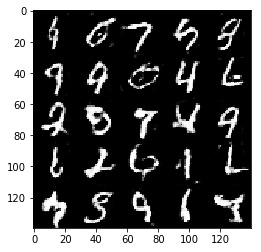

Epoch 2/2... Batch 200 Discriminator Loss: 1.2755... Generator Loss: 0.8405


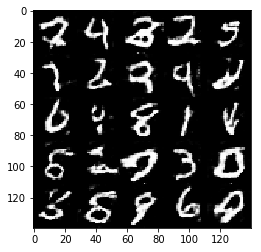

Epoch 2/2... Batch 300 Discriminator Loss: 1.2783... Generator Loss: 0.6935


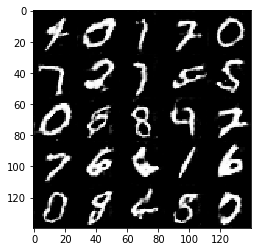

Epoch 2/2... Batch 400 Discriminator Loss: 1.0643... Generator Loss: 1.8097


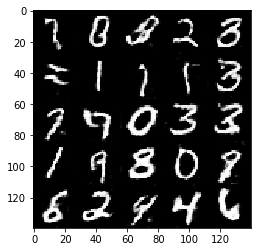

Epoch 2/2... Batch 500 Discriminator Loss: 1.0900... Generator Loss: 1.3948


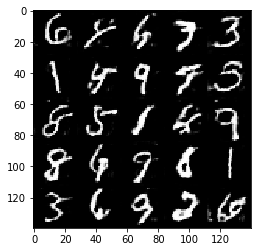

Epoch 2/2... Batch 600 Discriminator Loss: 1.4141... Generator Loss: 0.4619


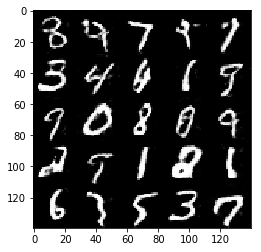

Epoch 2/2... Batch 700 Discriminator Loss: 0.9128... Generator Loss: 1.5914


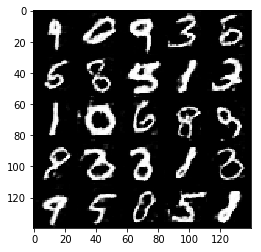

Epoch 2/2... Batch 800 Discriminator Loss: 1.0644... Generator Loss: 0.8597


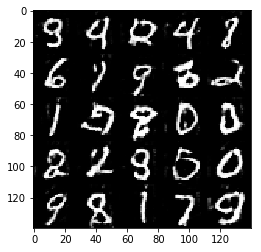

Epoch 2/2... Batch 900 Discriminator Loss: 1.1402... Generator Loss: 2.8641


In [13]:
batch_size = 64
z_dim = 100
learning_rate = 0.001
beta1 = 0.1


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train_v2(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

## After first review, I was modifyed. This is version 2.

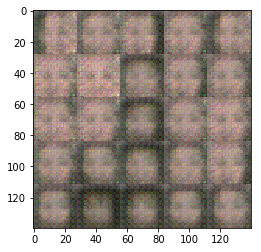

Epoch 1/1... Batch 100 Discriminator Loss: 1.5348... Generator Loss: 1.1068


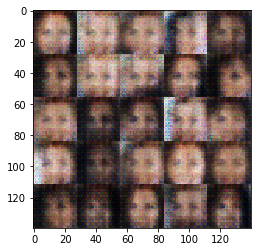

Epoch 1/1... Batch 200 Discriminator Loss: 1.2691... Generator Loss: 0.7568


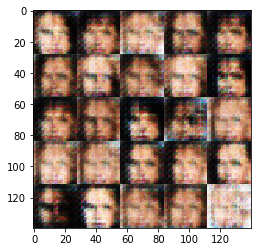

Epoch 1/1... Batch 300 Discriminator Loss: 2.0468... Generator Loss: 0.2294


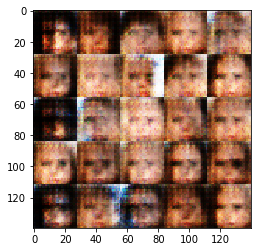

Epoch 1/1... Batch 400 Discriminator Loss: 1.2575... Generator Loss: 0.8014


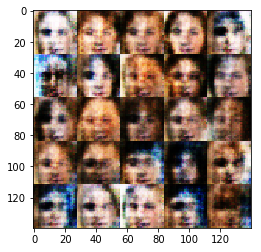

Epoch 1/1... Batch 500 Discriminator Loss: 1.4477... Generator Loss: 0.4734


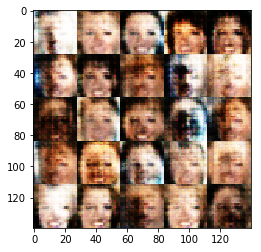

Epoch 1/1... Batch 600 Discriminator Loss: 1.5224... Generator Loss: 0.5037


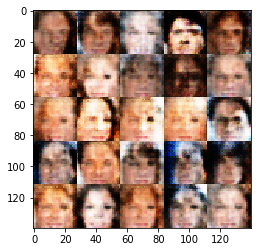

Epoch 1/1... Batch 700 Discriminator Loss: 1.0963... Generator Loss: 0.8086


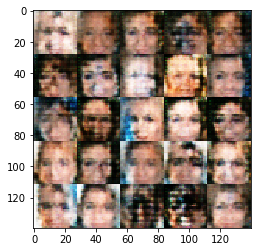

Epoch 1/1... Batch 800 Discriminator Loss: 1.2025... Generator Loss: 0.8937


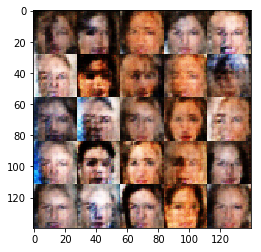

Epoch 1/1... Batch 900 Discriminator Loss: 1.2071... Generator Loss: 1.2822


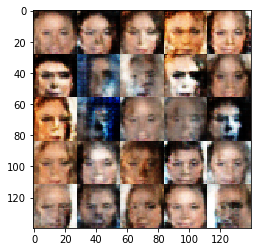

Epoch 1/1... Batch 1000 Discriminator Loss: 1.1059... Generator Loss: 0.9467


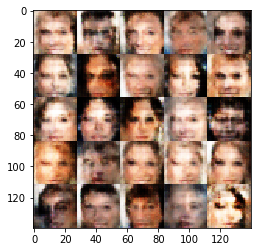

Epoch 1/1... Batch 1100 Discriminator Loss: 1.3645... Generator Loss: 0.6244


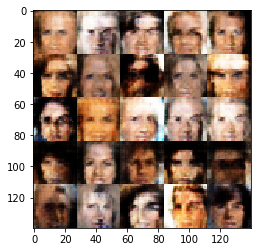

Epoch 1/1... Batch 1200 Discriminator Loss: 1.7570... Generator Loss: 2.2246


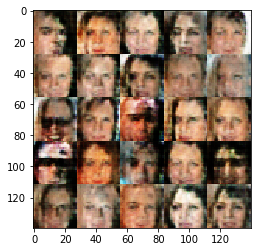

Epoch 1/1... Batch 1300 Discriminator Loss: 1.1479... Generator Loss: 0.9826


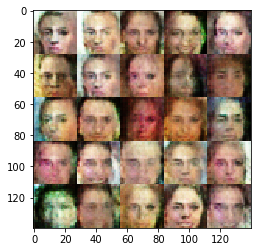

Epoch 1/1... Batch 1400 Discriminator Loss: 1.3127... Generator Loss: 0.9222


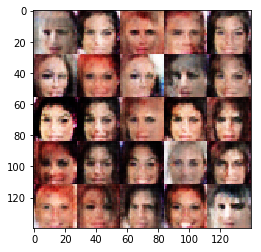

Epoch 1/1... Batch 1500 Discriminator Loss: 1.3151... Generator Loss: 0.9080


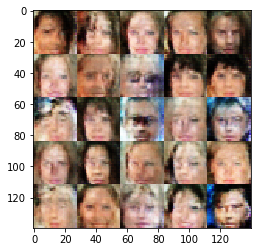

Epoch 1/1... Batch 1600 Discriminator Loss: 1.3255... Generator Loss: 1.5343


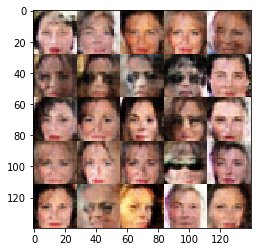

Epoch 1/1... Batch 1700 Discriminator Loss: 1.3853... Generator Loss: 0.5504


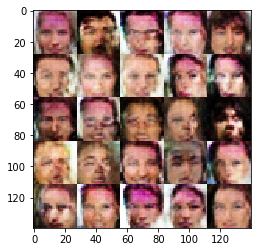

Epoch 1/1... Batch 1800 Discriminator Loss: 1.0897... Generator Loss: 0.8051


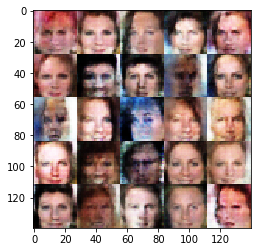

Epoch 1/1... Batch 1900 Discriminator Loss: 1.2213... Generator Loss: 0.7483


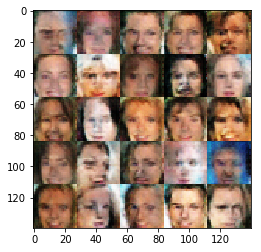

Epoch 1/1... Batch 2000 Discriminator Loss: 1.1379... Generator Loss: 0.7504


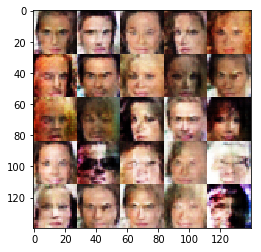

Epoch 1/1... Batch 2100 Discriminator Loss: 1.4167... Generator Loss: 2.0001


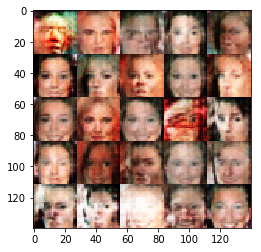

Epoch 1/1... Batch 2200 Discriminator Loss: 1.3714... Generator Loss: 0.6331


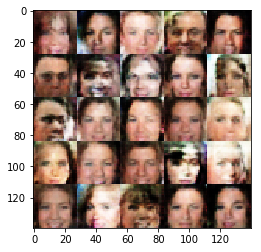

Epoch 1/1... Batch 2300 Discriminator Loss: 1.2824... Generator Loss: 0.8739


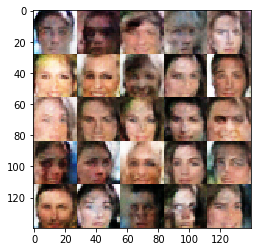

Epoch 1/1... Batch 2400 Discriminator Loss: 1.3199... Generator Loss: 0.5469


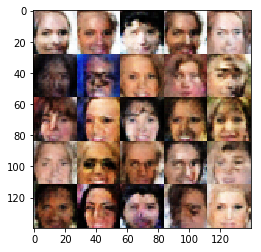

Epoch 1/1... Batch 2500 Discriminator Loss: 1.2673... Generator Loss: 1.5353


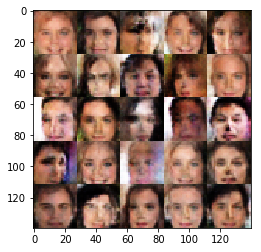

Epoch 1/1... Batch 2600 Discriminator Loss: 1.3196... Generator Loss: 0.6712


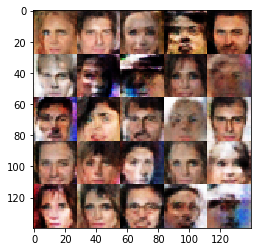

Epoch 1/1... Batch 2700 Discriminator Loss: 1.4086... Generator Loss: 0.5785


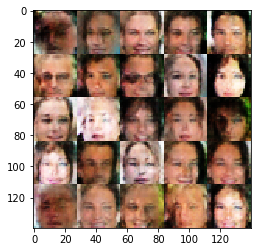

Epoch 1/1... Batch 2800 Discriminator Loss: 1.1490... Generator Loss: 0.9510


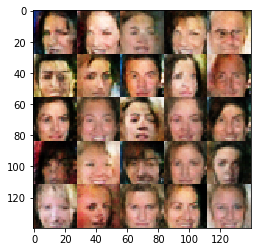

Epoch 1/1... Batch 2900 Discriminator Loss: 1.4533... Generator Loss: 1.3892


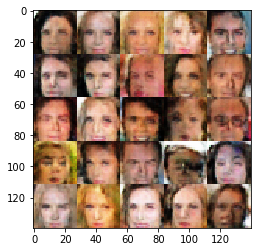

Epoch 1/1... Batch 3000 Discriminator Loss: 1.4504... Generator Loss: 0.4929


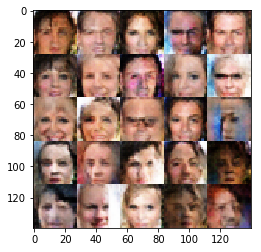

Epoch 1/1... Batch 3100 Discriminator Loss: 1.1989... Generator Loss: 0.6719


In [14]:
batch_size = 64
z_dim = 128
learning_rate = 0.001
beta1 = 0.1

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train_v2(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.